In [1]:
import numpy as np
import sys, json, copy, time, pickle, random
from concurrent.futures import ThreadPoolExecutor
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.providers.aer.noise import NoiseModel, pauli_error, amplitude_damping_error, ReadoutError
import qiskit.ignis.verification.randomized_benchmarking as rb
# from qiskit.providers.aer.noise.errors.errorutils import single_qubit_clifford_gates
# from qiskit.providers.ibmq.managed import IBMQJobManager, ManagedJobSet
# sfrom qiskit.providers.ibmq.apiconstants import ApiJobShareLevel
from qiskit.qobj.utils import MeasLevel
from sympy import N
from qubit_map import qubit_maps
import matplotlib.pyplot as plt
from scipy.stats import sem, unitary_group
# from scipy import sparse
import CB_process
from statistics import stdev
import itertools
# from qiskit.compiler import transpile
from scipy.stats.mstats import gmean
#Change test

use_density_matrix = False # density matrix based / measurement based simulation

filename_label = 'ibmq_experiment_all_20220228_8530634712' #exp1



with open('data/' + filename_label + '_result', 'rb') as infile:
    result = pickle.load(infile)

C = result['cb']['C']
shots = result['cb']['shots']
C_intc = result['intc_cb']['C']
shots_intc = result['intc_cb']['shots']
Lrange = result['cb']['Lrange']


In [2]:
# ### result without CNOT
# ref_fidelity = {'II': 1.0, 'IX': 0.9995586853033112, 'XI': 0.9990183385121216, 'XX': 0.9987004952565428, 'IY': 0.9996677250330002, 'XY': 0.9987807880415682, 'IZ': 0.99954865526102, 'XZ': 0.9984377273575964, 'YI': 0.9994254924455269, 'YX': 0.999164103754455, 'YY': 0.9990558181816186, 'YZ': 0.9988892426221504, 'ZI': 0.9992112734550366, 'ZX': 0.9987864235598634, 'ZY': 0.9988648391439333, 'ZZ': 0.9986665018013446}

Text(0, 0.5, 'Fidelity')

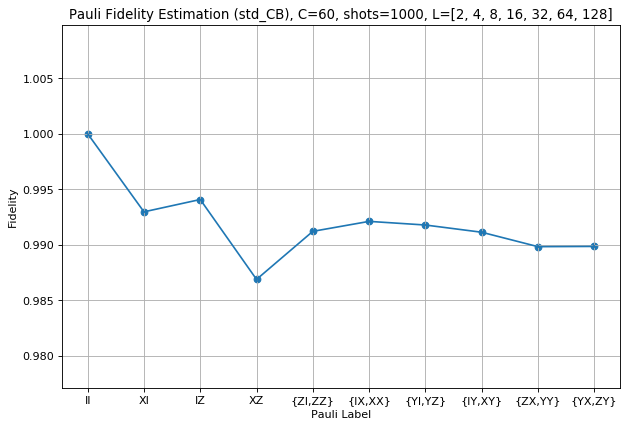

In [3]:


########### std_CB estimate
cb_fidelity_list = result['cb']['fidelity']
cb_stdev_list = result['cb']['stdev']

deg_list1 = ['II','XI','IZ','XZ','{ZI,ZZ}','{IX,XX}','{YI,YZ}','{IY,XY}','{ZX,YY}','{YX,ZY}']
cb_deg_fidelity = {} 
cb_deg_stdev = {}
# cb_true = {}
for label in deg_list1:
    if len(label) == 2:
        cb_deg_fidelity[label] = cb_fidelity_list[label]
        cb_deg_stdev[label] = cb_stdev_list[label]
        # cb_true[label] = f_true[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        cb_deg_fidelity[label] = (cb_fidelity_list[pp1]+cb_fidelity_list[pp2])/2
        cb_deg_stdev[label] = np.sqrt(cb_stdev_list[pp1]**2 + cb_stdev_list[pp2]**2)
        # cb_true[label] = (f_true[pp1] + f_true[pp2])/2


plt.figure(figsize=(9, 6), dpi=80)
n=2
plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
plt.errorbar(deg_list1,[cb_deg_fidelity[x] for x in deg_list1],[cb_deg_stdev[x] for x in deg_list1])
# plt.scatter(deg_list1,[f_true[x] for x in deg_list1],,c='red',marker='x')
# plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
# plt.plot(deg_list1,[cb_true[x] for x in deg_list1],ls=':',c='red')

# for label in deg_list1:
#     if len(label) == len('II'):
#         plt.scatter(label,f_true[label],c='red',marker='x')
#     else:
#         plt.scatter(label,f_true[label[1:3]],c='red',marker='x')
#         plt.scatter(label,f_true[label[4:6]],c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
plt.title("Pauli Fidelity Estimation (std_CB), C=%d, shots=%d, L=%s"%(C,shots,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")



In [4]:
cb_deg_stdev

{'II': 0.0,
 'XI': 0.00010506921174331797,
 'IZ': 6.917004659369425e-05,
 'XZ': 0.00019556060338833399,
 '{ZI,ZZ}': 0.00016973554208841012,
 '{IX,XX}': 0.00012611452208175698,
 '{YI,YZ}': 0.0001258307859725699,
 '{IY,XY}': 0.00014427764839341714,
 '{ZX,YY}': 0.00015055014197243202,
 '{YX,ZY}': 0.00016450181599519348}

In [5]:
for key,item in cb_deg_fidelity.items():
    print(key,1-item)

II 0.0
XI 0.007034828540997018
IZ 0.005923896165871412
XZ 0.013121349393790172
{ZI,ZZ} 0.008791544723703804
{IX,XX} 0.007893782594263432
{YI,YZ} 0.00822177511392641
{IY,XY} 0.008872826959891666
{ZX,YY} 0.01017127464642853
{YX,ZY} 0.010149335141323323


Text(0, 0.5, 'Fidelity')

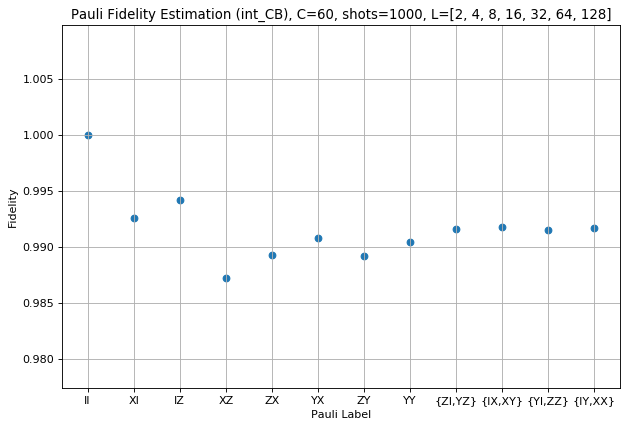

In [6]:
########### int_CB estimate
icb_fidelity_list = result['int_cb']['fidelity']
icb_stdev_list = result['int_cb']['stdev']

deg_list2 = ['II','XI','IZ','XZ','ZX','YX','ZY','YY','{ZI,YZ}','{IX,XY}','{YI,ZZ}','{IY,XX}']
icb_deg_fidelity = {} 
icb_deg_stdev = {}
# icb_true = {}
for label in deg_list2:
    if len(label) == 2:
        icb_deg_fidelity[label] = icb_fidelity_list[label]
        icb_deg_stdev[label] = icb_stdev_list[label]
        # icb_true[label] = f_true[label]
    else:
        pp1 = label[1:3]
        pp2 = label[4:6]
        icb_deg_fidelity[label] = (icb_fidelity_list[pp1]+icb_fidelity_list[pp2])/2
        icb_deg_stdev[label] = np.sqrt(icb_stdev_list[pp1]**2 + icb_stdev_list[pp2]**2)
        # icb_true[label] = (f_true[pp1]+f_true[pp2])/2


plt.figure(figsize=(9, 6), dpi=80)
n=2
plt.scatter(deg_list2,[icb_deg_fidelity[x] for x in deg_list2])
#plt.errorbar(deg_list2,[icb_deg_fidelity[x] for x in deg_list2],[icb_deg_stdev[x] for x in deg_list2])
# plt.scatter(deg_list1,[f_true[x] for x in deg_list1],,c='red',marker='x')
# plt.scatter(deg_list1,[cb_deg_fidelity[x] for x in deg_list1])
# plt.plot(deg_list2,[icb_true[x] for x in deg_list2],ls=':',c='red')
# for label in deg_list2:
#     if len(label) == len('II'):
#         plt.scatter(label,f_true[label],c='red',marker='x')
#     else:
#         plt.scatter(label,f_true[label[1:3]],c='red',marker='x')
#         plt.scatter(label,f_true[label[4:6]],c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
#plt.title("Pauli Fidelity Estimation (int_CB), C=%d, shots=%d"%(C,shots) +", L=",+str(Lrange))
plt.title("Pauli Fidelity Estimation (int_CB), C=%d, shots=%d, L=%s"%(C,shots,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")


In [7]:
####### compare redundacy, for real this time
snr_std = 0
for label,f in cb_deg_fidelity.items():
    if len(label)==len('II'):
        snr_std += f
    else:
        snr_std +=2*f
snr_std /= 16

snr_int = 0
for label,f in icb_deg_fidelity.items():
    if len(label)==len('II'):
        snr_int += f
    else:
        snr_int +=2*f
snr_int /= 16

print('ENR', str(1-snr_std), str(1-snr_int),'(',str(abs(snr_int-snr_std)/(1-snr_std)),')')
####### detailed compare
for label in ['XI','IZ','XZ']:
    print(label, str(1-cb_deg_fidelity[label]), str(1-icb_deg_fidelity[label]))

for label in ['{ZX,YY}','{YX,ZY}']:
    print(label, str(1-cb_deg_fidelity[label]), str(1-icb_deg_fidelity[label[1:3]]/2-icb_deg_fidelity[label[4:6]]/2))

ENR 0.008392572028733447 0.00832649662086582 ( 0.00787308201126026 )
XI 0.007034828540997018 0.007384314778511647
IZ 0.005923896165871412 0.005838417190853651
XZ 0.013121349393790172 0.012811023639746955
{ZX,YY} 0.01017127464642853 0.010121974899459707
{YX,ZY} 0.010149335141323323 0.010004365035165108


In [8]:
import sympy as sp
# Create a symbol x
x1 = sp.symbols("x_1") # 1-lambda_IX
x2 = sp.symbols("x_2") # 1-lambda_ZI

full_fidelity = {}
full_stdev = {}

full_fidelity['II'] = 1.0
full_stdev['II'] = 0.0
for label in ['XI','IZ','XZ']:
    full_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    full_stdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    full_fidelity[label] = icb_fidelity_list[label]
    full_stdev[label] = icb_stdev_list[label]

full_fidelity['IX'] = 1-x1
full_fidelity['XX'] = cb_deg_fidelity['{IX,XX}']**2 * (1+x1)
full_fidelity['XY'] = icb_deg_fidelity['{IX,XY}']**2 * (1+x1)
full_fidelity['IY'] = icb_deg_fidelity['{IY,XX}']**2/cb_deg_fidelity['{IX,XX}']**2 * (1-x1)

full_fidelity['ZI'] = 1-x2
full_fidelity['ZZ'] = cb_deg_fidelity['{ZI,ZZ}']**2 * (1+x2)
full_fidelity['YZ'] = icb_deg_fidelity['{ZI,YZ}']**2 * (1+x2)
full_fidelity['YI'] = icb_deg_fidelity['{YI,ZZ}']**2/cb_deg_fidelity['{ZI,ZZ}']**2 * (1-x2)

for key,item in full_fidelity.items():
    print(key,1-item)


II 0.0
XI 0.0072095716597543325
IZ 0.005881156678362531
XZ 0.012966186516768508
ZX 0.010685413002723965
YX 0.009241752854470708
ZY 0.010766977215859619
YY 0.009558536796195338
IX x_1
XX 0.0157252533848814 - 0.984274746615119*x_1
XY 0.0164602990237067 - 0.983539700976293*x_1
IY 0.999148391484895*x_1 + 0.000851608515105129
ZI x_2
ZZ 0.0175057981887787 - 0.982494201811221*x_2
YZ 0.016676822086729 - 0.983323177913271*x_2
YI 1.00055873443565*x_2 - 0.00055873443564769


In [9]:
######### Pauli error rate calculation
######### Todo: add variance estimation
def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    
full_error = fidelity_to_error(full_fidelity,n)

# for key,item in full_error.items():
#     print(key,item.subs(x1,0.01).subs(x2,0.013))

learnable_pauli = ['II','XI','IZ','XZ','ZX','YY','YX','ZY']
for key in learnable_pauli:
    print(key,full_error[key].subs(x1,0.01).subs(x2,0.013))

# full_error_clear = fidelity_to_error(full_fidelity_clear,n)
# full_error

# true_error = fidelity_to_error(f_true,n)

#### Linear programming -> feasible region

II 0.991641523841383
XI 0.000932549256427567
IZ 0.000841921370367958
XZ 6.97768180998865e-5
ZX 1.73937706807607e-5
YY -3.12285090858173e-5
YX 1.07609988303613e-5
ZY 3.42091949118121e-5


In [10]:
def feasible(x,y,eps=0):
    # d = x.shape[0]
    fm = np.ones(shape=x.shape).astype(bool)
    ### lambda<1
    for label in ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']:
        c = float(full_fidelity[label].subs(x1,0).subs(x2,0))
        a1 = float(full_fidelity[label].subs(x1,1).subs(x2,0)) - c
        a2 = float(full_fidelity[label].subs(x1,0).subs(x2,1)) - c

        # a1*x1 + a2*x2 + c
        fm = fm & (a1*x + a2*y + c <= 1)

    ### prob>0
    for label in ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']:
    #for label in ['II','XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']:
        c = float(full_error[label].subs(x1,0).subs(x2,0))
        a1 = float(full_error[label].subs(x1,1).subs(x2,0)) - c
        a2 = float(full_error[label].subs(x1,0).subs(x2,1)) - c
        # a1*x1 + a2*x2 + c
        fm = fm & (a1*x + a2*y + c >= -eps)

    return fm
    



In [11]:
# def feasible(x,y,eps=0):
#     # d = x.shape[0]
#     fm = np.ones(shape=x.shape).astype(bool)
#     ### lambda<1
#     for label in ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']:
#         c = float(full_fidelity_clear[label].subs(x1,0).subs(x2,0))
#         a1 = float(full_fidelity_clear[label].subs(x1,1).subs(x2,0)) - c
#         a2 = float(full_fidelity_clear[label].subs(x1,0).subs(x2,1)) - c

#         # a1*x1 + a2*x2 + c
#         fm = fm & (a1*x + a2*y + c <= 1)

#     ### prob>1-eps
#     for label in ['IX','XX','IY','XY','ZI','ZZ','YZ','YI']:
#     #for label in ['II','XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']:
#         c = float(full_error_clear[label].subs(x1,0).subs(x2,0))
#         a1 = float(full_error_clear[label].subs(x1,1).subs(x2,0)) - c
#         a2 = float(full_error_clear[label].subs(x1,0).subs(x2,1)) - c
#         # a1*x1 + a2*x2 + c
#         fm = fm & (a1*x + a2*y + c >= -eps)

#     return fm
    

(1000, 1000)


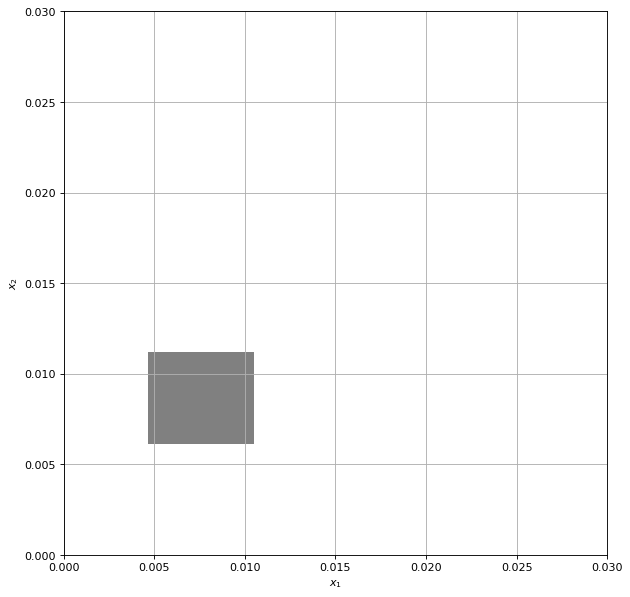

In [12]:
### plot feasible region
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9), dpi=80)

# plot the feasible region
d = np.linspace(0,0.03,1000)
x,y = np.meshgrid(d,d)
print(x.shape)
eps = 0
#plt.imshow( (feasible(x,y,eps)), extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);
feasible_grid = feasible(x,y)
plt.imshow( feasible_grid.astype(int) , 
                extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.5)


# plt.imshow( (feasible(x,y,1e-4)).astype(int) , 
#                 extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3)
# plt.imshow( (feasible(x,y,1e-3)).astype(int) , 
#                 extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.1)
# plt.imshow( (feasible(x,y,1)).astype(int) , 
#                 extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.2)
# # plot the lines defining the constraints
# x = np.linspace(0, 16, 2000)
# # y >= 2
# y1 = (x*0) + 2
# # 2y <= 25 - x
# y2 = (25-x)/2.0
# # 4y >= 2x - 8 
# y3 = (2*x-8)/4.0
# # y <= 2x - 5 
# y4 = 2 * x -5

# # Make plot
# plt.plot(x, 2*np.ones_like(y1))
# plt.plot(x, y2, label=r'$2y\leq25-x$')
# plt.plot(x, y3, label=r'$4y\geq 2x - 8$')
# plt.plot(x, y4, label=r'$y\leq 2x-5$')
# plt.xlim(0,16)
# plt.ylim(0,11)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.grid('on')

In [13]:
#decide the boundary
#in a brute-force way

for k in range(len(d)):
    flag = False
    for j in range(len(d)):
        if feasible_grid[k][j] == True:
            flag = True
            break
    if flag:
        break
print("y_low",y[k][0])
y_l = y[k][0]

for k in range(len(d)-1,-1,-1):
    flag = False
    for j in range(len(d)):
        if feasible_grid[k][j] == True:
            flag = True
            break
    if flag:
        break
print("y_high",y[k][0])
y_h = y[k][0]

for k in range(len(d)):
    flag = False
    for j in range(len(d)):
        if feasible_grid[j][k] == True:
            flag = True
            break
    if flag:
        break
print("x_low",x[0][k])
x_l = x[0][k]

for k in range(len(d)-1,-1,-1):
    flag = False
    for j in range(len(d)):
        if feasible_grid[j][k] == True:
            flag = True
            break
    if flag:
        break
print("x_high",x[0][k])
x_h = x[0][k]


y_low 0.006126126126126126
y_high 0.011171171171171172
x_low 0.0046246246246246245
x_high 0.01048048048048048


In [14]:
# Find the boundary? silly method is fine

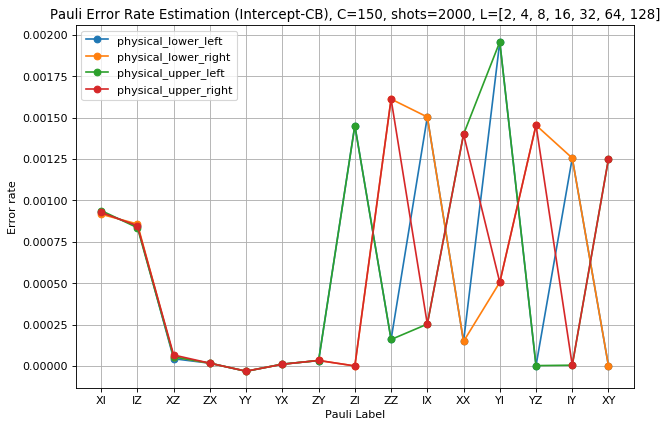

In [15]:
pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']
#pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','YI','ZZ','YZ','IX','IY','XX','XY']

plt.figure(figsize=(9, 6), dpi=80)
plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_l) for x in pauli_request_list),marker='o')
plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_l) for x in pauli_request_list),marker='o')
plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_l).subs(x2,y_h) for x in pauli_request_list),marker='o')
plt.plot(pauli_request_list,list(full_error[x].subs(x1,x_h).subs(x2,y_h) for x in pauli_request_list),marker='o')

# plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)

# plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Error rate")

plt.legend(['physical_lower_left','physical_lower_right','physical_upper_left','physical_upper_right'])

In [16]:
# pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']
# # for key in pauli_request_list:
# #     print(key,full_error[key].subs(x1,0.0075).subs(x2,0.0075),full_error[key].subs(x1,0.0049).subs(x2,0.0049))

# # print(1-full_error['II'])
# # print(1-sum(list(full_fidelity.values()))/16)

# plt.figure(figsize=(9, 6), dpi=80)
# plt.plot(pauli_request_list,list(full_error[x].subs(x1,0.01).subs(x2,0.013) for x in pauli_request_list),marker='o')
# plt.plot(pauli_request_list,list(full_error[x].subs(x1,0.016).subs(x2,0.0175) for x in pauli_request_list),marker='o')
# # plt.plot(pauli_request_list,list(full_error_intc[x] for x in pauli_request_list),marker='x')

# # plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)

# # plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')

# # plt.legend([1])
# plt.grid(True)
# # plt.ylim([0.8,1.005])
# # plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# plt.xlabel("Pauli Label")
# plt.ylabel("Error rate")

# plt.legend(['physical_lower_left','physical_upper_right'])

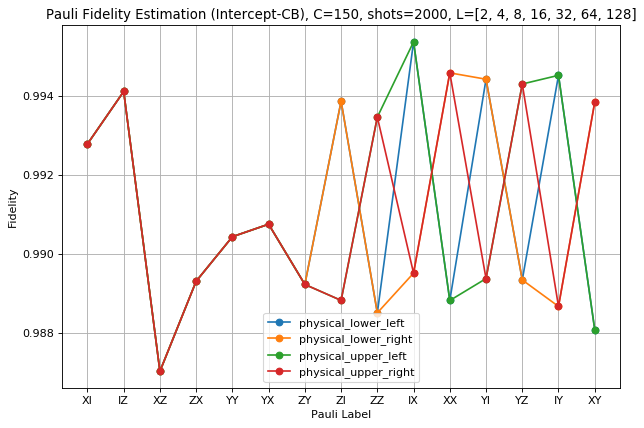

In [17]:
full_fidelity_1 = {}
full_fidelity_2 = {}
full_fidelity_3 = {}
full_fidelity_4 = {}
for label,value in full_fidelity.items():
    if type(value) == float or type(value) == int or type(value) == np.float64:
        full_fidelity_1[label] = value
        full_fidelity_2[label] = value
        full_fidelity_3[label] = value
        full_fidelity_4[label] = value
    else:
        full_fidelity_1[label] = value.subs(x1,x_l).subs(x2,y_l)
        full_fidelity_2[label] = value.subs(x1,x_h).subs(x2,y_l)
        full_fidelity_3[label] = value.subs(x1,x_l).subs(x2,y_h)
        full_fidelity_4[label] = value.subs(x1,x_h).subs(x2,y_h)

plt.figure(figsize=(9, 6), dpi=80)
plt.plot(pauli_request_list,list(full_fidelity_1[x] for x in pauli_request_list),marker='o')
plt.plot(pauli_request_list,list(full_fidelity_2[x] for x in pauli_request_list),marker='o')
plt.plot(pauli_request_list,list(full_fidelity_3[x] for x in pauli_request_list),marker='o')
plt.plot(pauli_request_list,list(full_fidelity_4[x] for x in pauli_request_list),marker='o')
#plt.plot(pauli_request_list,list(full_fidelity_intc[x] for x in pauli_request_list),marker='x')

# plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)

# plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
plt.title("Pauli Fidelity Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")

plt.legend(['physical_lower_left','physical_lower_right','physical_upper_left','physical_upper_right'])

In [18]:
# full_fidelity_1 = {}
# full_fidelity_2 = {}
# for label,value in full_fidelity.items():
#     if type(value) == float or type(value) == int or type(value) == np.float64:
#         full_fidelity_1[label] = value
#         full_fidelity_2[label] = value
#     else:
#         full_fidelity_1[label] = value.subs(x1,0.01).subs(x2,0.013)
#         full_fidelity_2[label] = value.subs(x1,0.016).subs(x2,0.0175)


# plt.figure(figsize=(9, 6), dpi=80)
# plt.plot(pauli_request_list,list(full_fidelity_1[x] for x in pauli_request_list),marker='o')
# plt.plot(pauli_request_list,list(full_fidelity_2[x] for x in pauli_request_list),marker='o')
# # plt.plot(pauli_request_list,list(full_fidelity_intc[x] for x in pauli_request_list),marker='x')

# # plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)

# # plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')

# # plt.legend([1])
# plt.grid(True)
# # plt.ylim([0.8,1.005])
# # plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
# plt.title("Pauli Fidelity Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
# plt.xlabel("Pauli Label")
# plt.ylabel("Fidelity")

# plt.legend(['physical_lower_left','physical_upper_right'])

In [19]:
# print("Label / Pauli infidelity / Standard deviation")
# pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)]
# for pauli_label in pauli_request_list:
#     print(pauli_label+" %.6f"%(1-full_fidelity_1[pauli_label]))

In [20]:
# ####### use intercept information (Todo: Stdev analysis)
full_fidelity = {}
full_stdev = {}

full_fidelity['II'] = 1.0
full_stdev['II'] = 0.0
for label in ['XI','IZ','XZ']:
    full_fidelity[label] = (cb_fidelity_list[label] + icb_fidelity_list[label])/2
    full_stdev[label] = np.sqrt(cb_stdev_list[label]**2 + icb_stdev_list[label]**2)
for label in ['ZX','YX','ZY','YY']:
    full_fidelity[label] = icb_fidelity_list[label]
    full_stdev[label] = icb_stdev_list[label]

full_fidelity['ZI'] = result['intc_cb']['dec_fidelity']['ZI']
full_fidelity['ZZ'] = result['intc_cb']['dec_fidelity']['ZZ']
full_fidelity['XX'] = result['intc_cb']['dec_fidelity']['XX']
full_fidelity['IX'] = result['intc_cb']['dec_fidelity']['IX']
full_fidelity['YZ'] = icb_deg_fidelity['{ZI,YZ}']**2/full_fidelity['ZI']
full_fidelity['YI'] = icb_deg_fidelity['{YI,ZZ}']**2/full_fidelity['ZZ']
full_fidelity['IY'] = icb_deg_fidelity['{IY,XX}']**2/full_fidelity['XX']
full_fidelity['XY'] = icb_deg_fidelity['{IX,XY}']**2/full_fidelity['IX']

full_stdev['ZI'] = result['intc_cb']['dec_stdev']['ZI']
full_stdev['ZZ'] = result['intc_cb']['dec_stdev']['ZZ']
full_stdev['XX'] = result['intc_cb']['dec_stdev']['XX']
full_stdev['IX'] = result['intc_cb']['dec_stdev']['IX']
full_stdev['YZ'] = np.sqrt(4 * icb_deg_fidelity['{ZI,YZ}']**2/full_fidelity['ZI']**2 * icb_deg_stdev['{ZI,YZ}']**2 + icb_deg_fidelity['{ZI,YZ}']**4/full_fidelity['ZI']**4 * full_stdev['ZI']**2)
full_stdev['YI'] = np.sqrt(4 * icb_deg_fidelity['{YI,ZZ}']**2/full_fidelity['ZZ']**2 * icb_deg_stdev['{YI,ZZ}']**2 + icb_deg_fidelity['{YI,ZZ}']**4/full_fidelity['ZZ']**4 * full_stdev['ZZ']**2)
full_stdev['IY'] = np.sqrt(4 * icb_deg_fidelity['{IY,XX}']**2/full_fidelity['XX']**2 * icb_deg_stdev['{IY,XX}']**2 + icb_deg_fidelity['{IY,XX}']**4/full_fidelity['XX']**4 * full_stdev['XX']**2)
full_stdev['XY'] = np.sqrt(4 * icb_deg_fidelity['{IX,XY}']**2/full_fidelity['IX']**2 * icb_deg_stdev['{IX,XY}']**2 + icb_deg_fidelity['{IX,XY}']**4/full_fidelity['IX']**4 * full_stdev['IX']**2)


Text(0, 0.5, 'Fidelity')

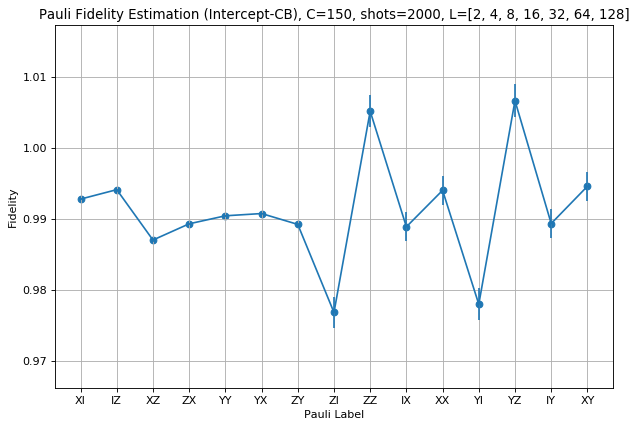

In [21]:
plt.figure(figsize=(9, 6), dpi=80)
n=2
#pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = n)]
pauli_request_list = ['XI','IZ','XZ','ZX','YY','YX','ZY','ZI','ZZ','IX','XX','YI','YZ','IY','XY']

plt.scatter(pauli_request_list,list(full_fidelity[x] for x in pauli_request_list))
plt.errorbar(pauli_request_list,list(full_fidelity[x] for x in pauli_request_list),yerr = list(full_stdev[x] for x in pauli_request_list))

# plt.scatter(pauli_request_list,list(f_true[x] for x in pauli_request_list),c='red',marker='x')
#plt.plot(pauli_request_list,list(f_true[x] for x in pauli_request_list),ls=':',c='red',marker='x')

plt.grid(True)
plt.title("Pauli Fidelity Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Fidelity")

Text(0, 0.5, 'Error rate')

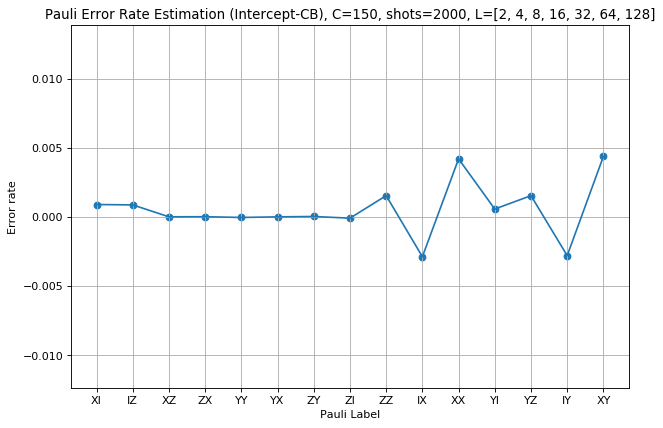

In [22]:
######### Pauli error rate calculation
######### Todo: add variance estimation
def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    
full_error = fidelity_to_error(full_fidelity,n)
# true_error = fidelity_to_error(f_true,n)



# n=2
# f_true_fid = {}
# f_dec_fid = {}
# for key,value in f_true.items():
#     f_true_fid[key] = 1-value
# for key,value in f_dec.items():
#     f_dec_fid[key] = 1-value

# true_pauli_error = fidelity_to_error(f_true_fid,n)
# intercept_pauli_error = fidelity_to_error(f_dec_fid,n)
# # print(true_pauli_error)
# # print(intercept_pauli_error)


plt.figure(figsize=(9, 6), dpi=80)
plt.scatter(pauli_request_list,list(full_error[x] for x in pauli_request_list))

plt.errorbar(pauli_request_list,list(full_error[x] for x in pauli_request_list),yerr = None)

# plt.scatter(pauli_request_list,list(true_error[x] for x in pauli_request_list),c='red',marker='x')

# plt.legend([1])
plt.grid(True)
# plt.ylim([0.8,1.005])
# plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d"%(C_intc,shots_intc) +", L=",+str(Lrange))
plt.title("Pauli Error Rate Estimation (Intercept-CB), C=%d, shots=%d, L=%s"%(C_intc,shots_intc,str(Lrange)))
plt.xlabel("Pauli Label")
plt.ylabel("Error rate")



In [23]:
# full_error_intc = full_error
# full_fidelity_intc = full_fidelity

In [24]:
# ################## calculate distance
# tvd = 0
# for key in full_error:
#     tvd += abs(full_error[key]-true_error[key])
# tvd /= 2

# print("TVD(p_CB,p_true) = %0.10f"%(tvd))

# f_l1_all = 0
# p_l1_all = 0
# f_l1_all_std = 0
# for key in full_error:
#     p_l1_all += abs(full_error[key]-true_error[key])
#     f_l1_all += abs(full_fidelity[key]-f_true[key])
#     f_l1_all_std += full_stdev[key]**2
# f_l1_all_std = np.sqrt(f_l1_all_std)

# p_l1_learnable = 0
# f_l1_learnable = 0
# f_l1_learnable_std = 0
# for key in ['XI','IZ','XZ','ZX','YY','YX','ZY']:
#     p_l1_learnable += abs(full_error[key]-true_error[key])
#     f_l1_learnable += abs(full_fidelity[key]-f_true[key])
#     f_l1_learnable_std += full_stdev[key]**2
# f_l1_learnable_std = np.sqrt(f_l1_learnable_std)

# print([f_l1_all,f_l1_all_std,f_l1_learnable,f_l1_learnable_std])

# print(p_l1_learnable)